# Connectivity Inference V2

This notebook applied the V2 of the connectivity inference on the adEx implementation of Taehoon of "Susin, Eduarda, and Alain Destexhe. 2021."

In [1]:
############################
######## SETUP  ###########

#####  General Imports ######
import numpy as np
from brian2 import *
from matplotlib import pyplot
import sys
import networkx

##### setup interactive ####
%matplotlib notebook 

In [2]:
#### Simulation Scripts #####
sys.path.append('../simulations/')
from wp2_adex_model_script import * 

###### Utility Scripts #####
sys.path.append('../tools')
#import wp2_util as  wp2_util

In [3]:
###########################
####### RUN SIMULATION ####

### choose parameters ###
params = dict()
params['sim_time'] = float(30) # simulation time in seconds 
params['a'] = float( 4*10**(-9))    # subthreshold adaption constant [Siemens]
params['b'] = float(0.0805 * 10**(-9)) # spike-triggert adaption constant [A ]
params['N'] = int(10) #  no of neurons
params['ge']=float(4) # excitatory synaptic conductance [nS ??] - [VALUE ???]
params['gi']=float(4) # inhibitory synaptic conductance [nS ??] - [VALUE ???]

root_dir = 'simData'

curr_dir = root_dir + '/' + str(params['N'])

#if(not(os.path.exists(curr_dir))):
#    os.makedirs(curr_dir)

params['save_fol'] = curr_dir


# run simulation
#trace, spikes, S = simpleNetV2(n, p, c, t, ws, tauw, a, b, Vr) # Regular spiking 
result = run_sim(params)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]


The time difference is : 30.892934013
[ 16.9  17.2  17.3  17.8  18.4  18.5  18.7  19.3  27.7  27.9  27.9  28.1
  28.2  28.3  28.3  28.7  38.7  38.8  39.2  39.2  39.6  40.   40.   40.9
  49.3  50.   50.2  50.2  50.4  50.6  50.6  51.   57.5  58.7  58.8  58.8
  59.   59.1  59.1  59.4  92.8  93.9  93.9  93.9  94.   94.   94.   94.1
 103.1 104.5 104.5 104.5 104.5 104.5 104.5 104.6]
[10.6 13.4 14.4 16.7 17.6 22.  25.  25.8 26.3 26.7 30.4 36.  39.4 44.5
 46.4 46.6 50.  50.6 52.6 54.6 56.6 57.  87.5 88.4 90.  98.1 99.2 99.3]
simulation successfullly ran for 10_4e-09_8.05e-11_30.0_4.0_4.0


<IPython.core.display.Javascript object>


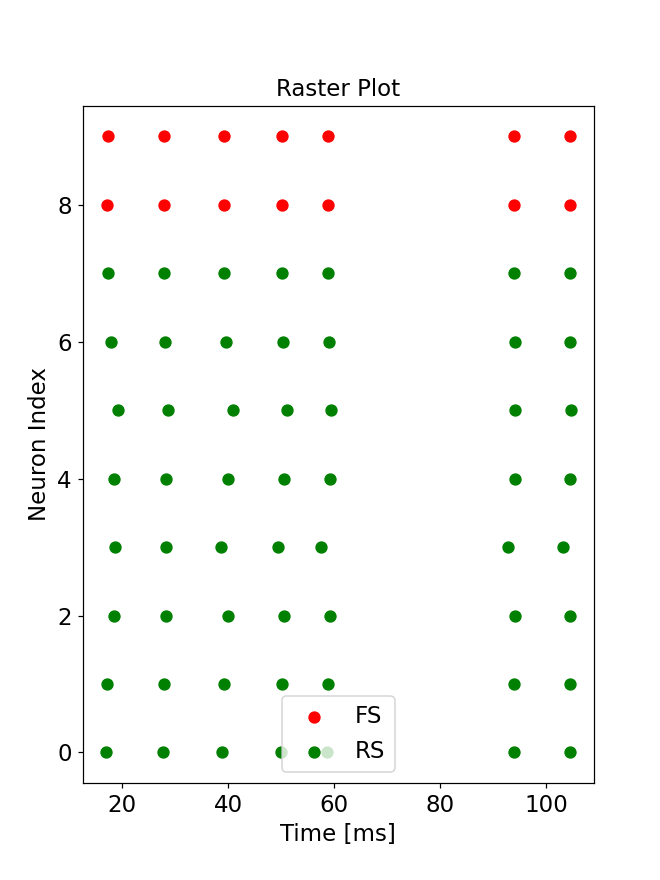

<IPython.core.display.Javascript object>


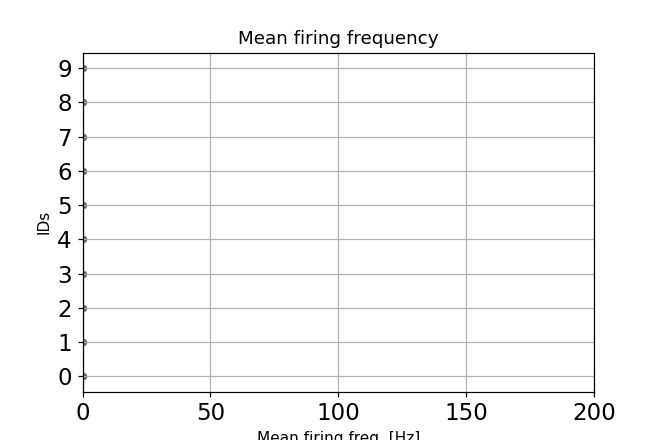

In [4]:
###########################
####### SHOW DATA #########

##### raster plot
Fig=plt.figure(figsize=(6,8))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


figa=Fig.add_subplot()
plt.title('Raster Plot', fontsize=15)
plt.scatter(  result['in_time'], result['in_idx'], color='red',s=50,label="FS")
plt.scatter(  result['ex_time'], result['ex_idx'], color='green',s=50,label="RS")
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Neuron Index', fontsize=15) 

##### mean fireing freq.
fig = pyplot.figure(figsize=(6,4))

index, counts = np.unique( result['ex_idx'], return_counts=True)
pyplot.scatter(counts/1000, index , s=15, c=[[.4,.4,.4]], label="RS")

index, counts = np.unique(result['in_idx'], return_counts=True)
pyplot.scatter(counts/1000, index , s=15, c=[[.4,.4,.4]], label="FS")


pyplot.yticks(np.arange(0,result['NI']+result['NE'], 1)) # tick every 1 neuron(s)
pyplot.xlim([0,200])
pyplot.ylabel('IDs')
pyplot.xlabel('Mean firing freq. [Hz]')
pyplot.title('Mean firing frequency')
pyplot.grid()
pyplot.show()

In [173]:
#### Cross-Correlation Histogram ###

# select neurons to correlate - currently excitory only
id_x = 2
id_y = 4

#### get timestamps of spikes of neuron x and y 
ii_x = np.where(result['ex_idx'] == id_x)
ii_y = np.where(result['ex_idx'] == id_y)

time_x = numpy.around(result['ex_time'][ii_x],1)
time_y = numpy.around(result['ex_time'][ii_y],1)

#make pandas array of timeseries for both neurons
dt = 0.1 # ms

times = numpy.arange(0,params['sim_time']*1000,dt)

column_values = [ 'times']

    
# creating the dataframe
df = pd.DataFrame(data = times, 
                  #index = index_values, 
                  columns = column_values)

df['neuron_x'] = 0
df['neuron_y'] = 0

# Applying the condition -  set fire neurons to true
df.loc[[x in time_x for x in df['times']], "neuron_x"] = 1
df.loc[[x in time_y for x in df['times']], "neuron_y"] = 1

# show data frame
df

,times,neuron_x,neuron_y
0,0.0,0,0
1,0.1,0,0
2,0.2,0,0
3,0.3,0,0
4,0.4,0,0
...,...,...,...
299995,29999.5,0,0
299996,29999.6,0,0
299997,29999.7,0,0
299998,29999.8,0,0


<IPython.core.display.Javascript object>


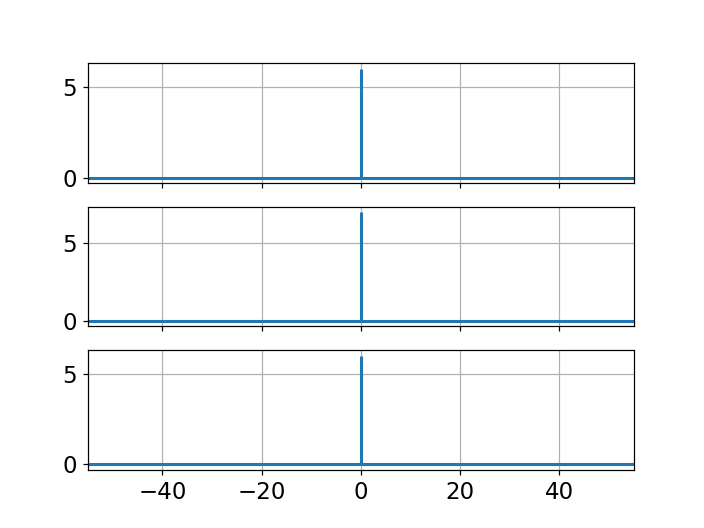

AttributeError: 'AxesSubplot' object has no attribute 'xlim'

In [174]:
# Fixing random state for reproducibility
#np.random.seed(19680801)
#x, y = np.random.randn(2, 100)

x = df['neuron_x'].tolist()
y = df['neuron_y'].tolist()


fig, [ax1, ax2, ax3] = plt.subplots(3, 1, sharex=True)

ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=False, lw=2)
ax1.grid(True)

ax2.acorr(x, usevlines=True, normed=False, maxlags=50, lw=2)
ax2.grid(True)

ax3.acorr(y, usevlines=True, normed=False, maxlags=50, lw=2)
ax3.grid(True)

ax1.xlim(0,)

plt.show()

In [172]:
# of cross correlation of entire series
df['neuron_x'].corr(df['neuron_y'])

0.9258185567069632